# Estadistica aplicada
sesion 17

26 octubre 2023

Francisco Javier Chávez Hernández 2034204 gpo44

In [3]:
#librerias basicas
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
#especializadas
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_predict

#ARIMA
from statsmodels.tsa.arima.model import ARIMA
#pmdarima 
import pmdarima as pm

In [5]:
#datos
desempleo_mx=pd.read_excel('desempleo_mex.xlsx')

In [6]:
desempleo_mx.head()

,meses,tasa de desempleo
0,2005/01,3.951998
1,2005/02,3.773302
2,2005/03,3.627075
3,2005/04,3.363412
4,2005/05,3.303693


In [7]:
desempleo_mx.dtypes

meses                 object
tasa de desempleo    float64
dtype: object

In [8]:
desempleo_mx.isnull().sum()

meses                0
tasa de desempleo    0
dtype: int64

In [9]:
#formato fecha, index, frecuencia
desempleo_mx['meses']=pd.to_datetime(desempleo_mx['meses'], format='%Y/%m')
desempleo_mx=desempleo_mx.set_index('meses')
desempleo_mx=desempleo_mx.asfreq('MS')

Text(0, 0.5, '%')

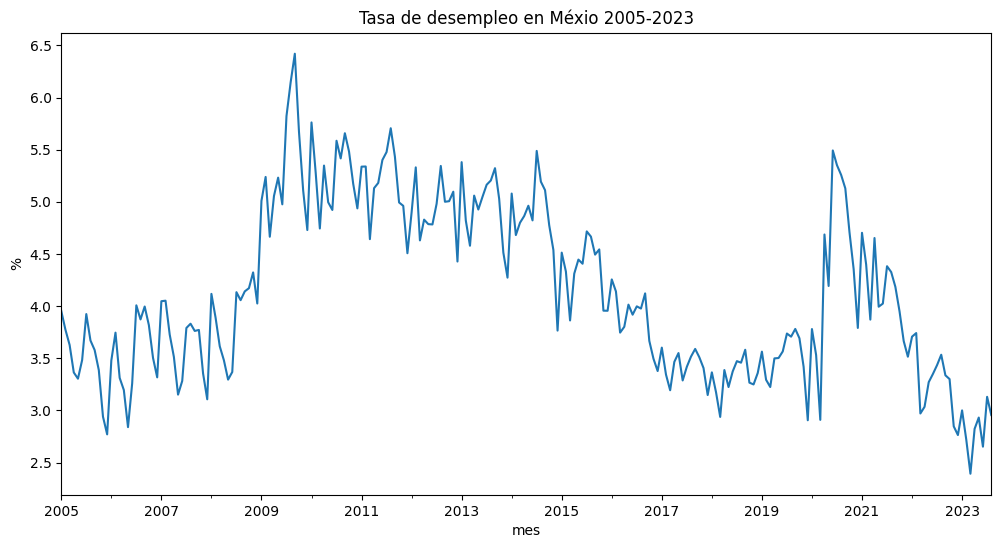

In [10]:
desempleo_mx['tasa de desempleo'].plot(figsize=(12,6))
plt.title('Tasa de desempleo en Méxio 2005-2023')
plt.xlabel('mes')
plt.ylabel('%')


In [11]:
#prueba de raiz unitaria
prueba_adf=adfuller(desempleo_mx['tasa de desempleo'])
pvalue=prueba_adf[1]
pvalue.round(2)

0.25

No rechazamos Ho, significa que la tasa de desempleo es una serie no estacionaria

<Axes: xlabel='meses'>

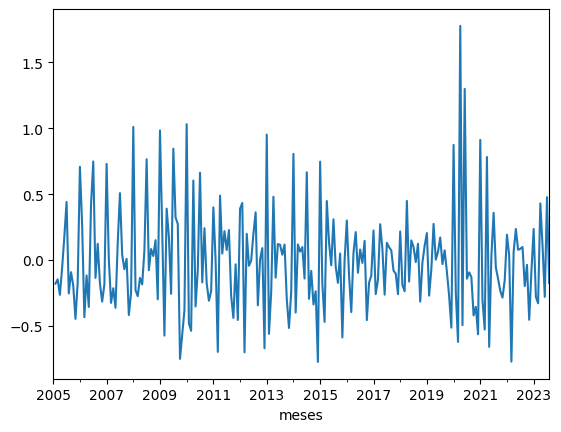

In [12]:
#primeras diferencias
desempleo_mx['desempleo_dif']=desempleo_mx['tasa de desempleo'].diff()
desempleo_mx['desempleo_dif'].plot()

In [13]:
#prueba de raiz unitaria
prueba_adf1=adfuller(desempleo_mx['desempleo_dif'].dropna())
pvalue1=prueba_adf1[1]
pvalue1.round(2)

0.01

Rechazamos Ho, significa que las primeras diferencias de desempleo es un proceso estacionario

* desempleo I(1)
* 1ras diferencias del desempleo integrado I(0)

# Identificar el nombre del proceso

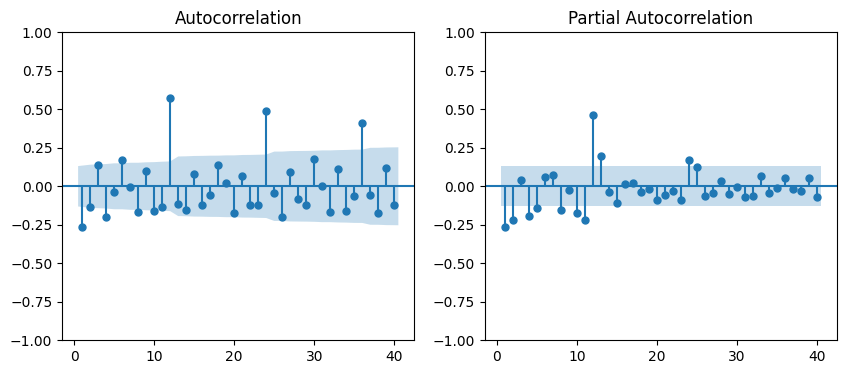

In [14]:
#graficas de correlacion
ig, ax=plt.subplots(1,2,figsize=(10,4))
#1er subgrafica
plot_acf(desempleo_mx['desempleo_dif'].dropna(),zero=False, lags=40, ax=ax[0])
#2da
plot_pacf(desempleo_mx['desempleo_dif'].dropna(),zero=False, lags=40, ax=ax[1])
plt.show()

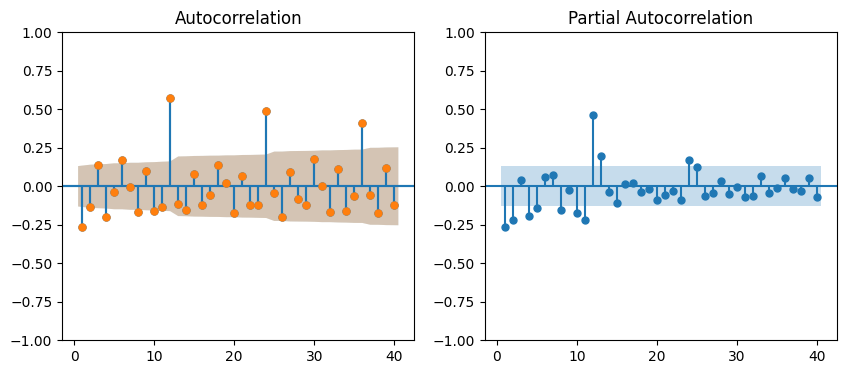

In [15]:
plt.rcParams['figure.figsize']=(14,4)
plot_acf(desempleo_mx['desempleo_dif'].dropna(),zero=False, lags=40, ax=ax[0])

las graficas de correlacion muestran un patron regular, lo que indica que estamos ante una serie con componente estaional; es decir, existen meses del año que la tasa de desempleo siempre sube y otros que la tasa de desempleo siempre baja

In [16]:
#identificar el orden del desempleo
pm.auto_arima(desempleo_mx['tasa de desempleo'],
              start_p=1,start_q=1,
              max_p=10, max_q=10,
              ic='aic',
              seasonal=True,
              m=12,
              start_P=1, start_Q=1,
              max_P=7, max_Q=7)

ARIMA(order=(1, 1, 0), scoring_args={}, seasonal_order=(1, 0, 1, 12),
      suppress_warnings=True, with_intercept=False)

La tasa de desempleo SARIMA (1,1,0)(1,0,1,12)

In [17]:
model=ARIMA(desempleo_mx['tasa de desempleo'], 
            order=(1,1,0),
            seasonal_order=(1,0,1,12))
results=model.fit()
print(results.summary())

                                     SARIMAX Results                                      
Dep. Variable:                  tasa de desempleo   No. Observations:                  224
Model:             ARIMA(1, 1, 0)x(1, 0, [1], 12)   Log Likelihood                 -28.306
Date:                            Thu, 26 Oct 2023   AIC                             64.613
Time:                                    12:14:49   BIC                             78.241
Sample:                                01-01-2005   HQIC                            70.115
                                     - 08-01-2023                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3689      0.061     -6.075      0.000      -0.488      -0.250
ar.S.L12       0.9763      0.014   

In [18]:
#pronosticando el pasado
desempleo_mx['desempleo_arima']=results.predict()

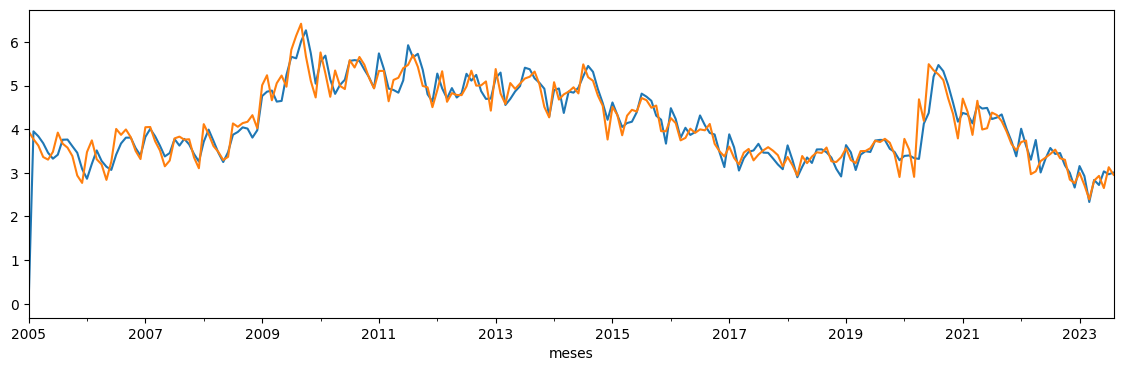

In [20]:
desempleo_mx['desempleo_arima'].plot()
desempleo_mx['tasa de desempleo'].plot()
plt.show()

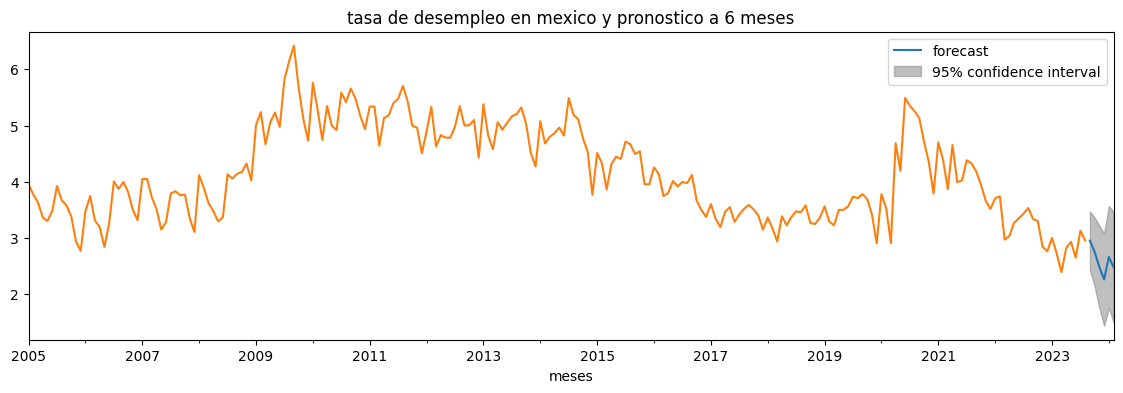

In [21]:
plot_predict(results,'2023-09-01','2024-02-01')
desempleo_mx['tasa de desempleo'].plot()
plt.title('tasa de desempleo en mexico y pronostico a 6 meses')
plt.show()

In [23]:
desempleo_mx.tail()

,tasa de desempleo,desempleo_dif,desempleo_arima
meses,,,
2023-04-01,2.822799,0.430258,2.837606
2023-05-01,2.931125,0.108327,2.722100
2023-06-01,2.652033,-0.279093,3.034390
2023-07-01,3.129870,0.477837,2.968333
2023-08-01,2.955346,-0.174524,3.007015


In [25]:
forecast=results.get_forecast(steps=6)
forecast_mean=forecast.predicted_mean
forecast_ci=forecast.conf_int()

In [31]:
inicio='2023-09-01'
fin='2024-02-01'

In [32]:
pronostico_valor=forecast_mean[inicio:fin]


In [33]:
pronostico_intervalos=forecast_ci.loc[inicio:fin]

In [38]:
#juntarlos en un dataframe
df_forecast=pd.DataFrame({
'pronostico':pronostico_valor,
'limite inferior':pronostico_intervalos.iloc[:,0],
'limite superior':pronostico_intervalos.iloc[:,1]
})

In [37]:
pronostico_intervalos

,lower tasa de desempleo,upper tasa de desempleo
2023-09-01,2.431389,3.472082
2023-10-01,2.135374,3.365963
2023-11-01,1.750114,3.217009
2023-12-01,1.439566,3.085317
2024-01-01,1.754471,3.569507
2024-02-01,1.498252,3.465324


In [39]:
df_forecast

,pronostico,limite inferior,limite superior
2023-09-01,2.951735,2.431389,3.472082
2023-10-01,2.750669,2.135374,3.365963
2023-11-01,2.483561,1.750114,3.217009
2023-12-01,2.262441,1.439566,3.085317
2024-01-01,2.661989,1.754471,3.569507
2024-02-01,2.481788,1.498252,3.465324


In [43]:
print(f'La tasa de desempleo pronosticada para septiembre de 2023 es {df_forecast.iloc[0,0].round(2)}%\nCon un 95% de confianza la tasa de desempleo estará entre {df_forecast.iloc[0,1].round(2)}% y {df_forecast.iloc[0,2].round(2)}%')

La tasa de desempleo pronosticada para septiembre de 2023 es 2.95%
Con un 95% de confianza la tasa de desempleo estará entre 2.43% y 3.47%


# Pronostico IPC BMV


In [84]:
ipc_bmv=pd.read_excel('ipc_bmv.xlsx')

In [85]:
ipc_bmv.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [86]:
#fecha as index
ipc_bmv=ipc_bmv.set_index('Date')

In [87]:
## frecuencia
ipc_bmv=ipc_bmv.asfreq('W-MON')

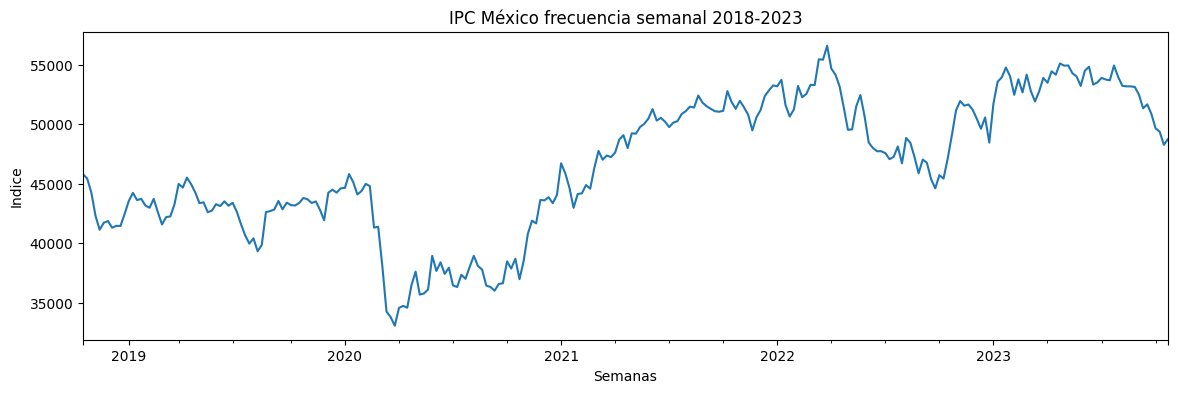

In [92]:
ipc_bmv['Adj Close'].plot()
plt.title('IPC México frecuencia semanal 2018-2023')
plt.ylabel('Indice')
plt.xlabel('Semanas')
plt.show()

In [93]:
# parece una caminata aleatoria
#prueba de raiz unitaria
prueba_adf=adfuller(ipc_bmv['Adj Close'].dropna())
pvalue=prueba_adf[1]
pvalue.round(2)

0.54

No rechazamos Ho, el IPC es una serie no estacionaria

In [94]:
ipc_bmv['ipc_dif']=ipc_bmv['Adj Close'].diff()

<Axes: xlabel='Date'>

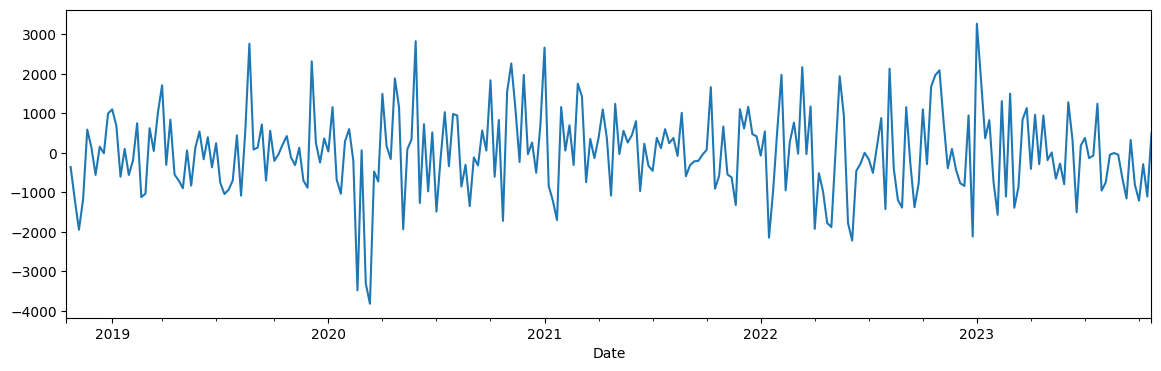

In [95]:
ipc_bmv['ipc_dif'].plot()

In [96]:
prueba_adf=adfuller(ipc_bmv['ipc_dif'].dropna())
pvalue1=prueba_adf1[1]
pvalue1.round(2)

0.01

rechazamos Ho, las primeras diferencia del IPC son una serie estacionaria

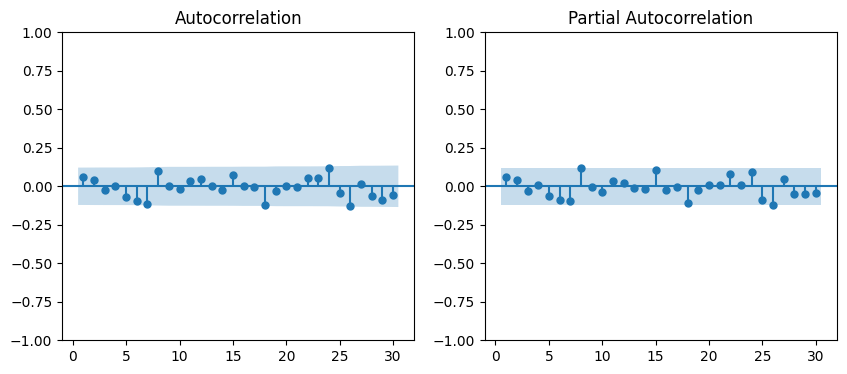

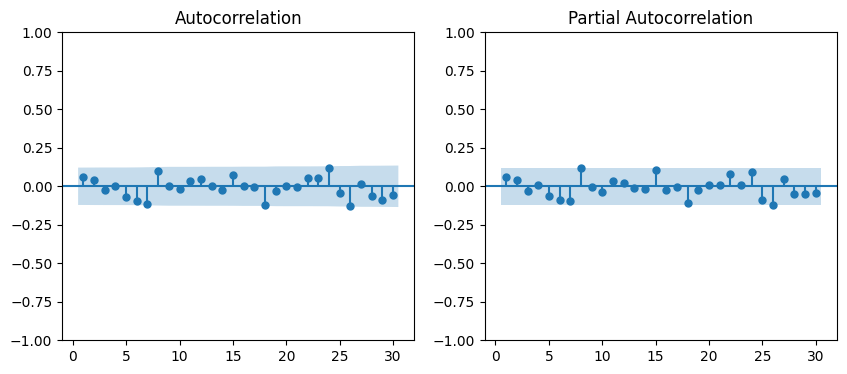

In [100]:
#grafica correlaciones
ig, ax=plt.subplots(1,2, figsize=(10,4))
#1
plot_acf(ipc_bmv['ipc_dif'].dropna(),zero=False, lags=30,ax=ax[0])
#2
plot_pacf(ipc_bmv['ipc_dif'].dropna(),zero=False, lags=30,ax=ax[1])

el ipx es una serie que no tiene componente estacional, porque no hay un patron repetitivo en las correlaciones

In [102]:
#determinar orden del ARIMA
pm.auto_arima(ipc_bmv['Adj Close'], 
              start_p=1, start_q=1,
              max_p=7, max_q=7,
              ic='aic',
              seasonal=False)

ARIMA(order=(0, 1, 0), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

Como IPC ARIMA (0,1,0), es ruido blanco, el IPC no se puede pronosticar. Las primeras diferencias son un ARIMA (0,0,0) o lo que es lo mismo es un ruido blanco y por lo tanto no se podría pronosticar con enfoque ARIMA 
